* pip install spotipy matplotlib requests pandas python-dotenv seaborn beautifulsoup4

In [62]:
import spotipy
import os
import pprint
import pandas as pd
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
from collections import Counter


In [63]:
load_dotenv()

True

In [64]:
#cache_path = os.path.join(os.getcwd(), "spotify_cache")

In [65]:
# auth and token
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id = os.getenv('SPOTIFY_CLIENT_ID'),
    client_secret = os.getenv('SPOTIFY_CLIENT_SECRET'),
    redirect_uri='http://localhost:8000/callback',
    scope='user-top-read, playlist-read-private',
    #cache_path=cache_path
))

## _clean dates fucntion_

In [66]:
# clean dates
# len() - str return int
# apply
def date_clean(date):
    if isinstance(date, str) and len(date) == 4 and date.isdigit():
        return int(date)
    elif isinstance(date, str):
        return pd.to_datetime(date, errors='coerce').year
    return date


# _get wiki function_

In [67]:
# get 'Genres' without slice or indices

def get_genres(artist_name):
    artist_name = artist_name.replace(" ", "_")

    url = f'https://en.wikipedia.org/wiki/{artist_name}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    table = soup.find("table", class_="infobox")
    if not table:
        return None
    
    for row in table.find_all('tr'):
        heading = row.find('th')

        if heading and 'Genres' in heading.text:
            data = row.find('td')
            genres = [li.text.strip() for li in data.find_all('li')]

            # ASK CHAPGPT TO CLEAN THE [5] ETC FROM THE STRING
            # BECAUSE REGEX MAKES MY BRAIN HURT
            # MORE THAT TRYING TO LEARN C++ AND REACT AT THE SAME TIME
            # ...
            # YES I ONCE THOUGHT THAT WAS A GOOD IDEA......

            genres = [re.sub(r"\[\d+\]", "", genre) for genre in genres]

            if not genres:
                genres = data.text.strip().split(', ')

            return genres
    return None

pprint.pprint(get_genres('Frank Ocean'))

['Alternative R&B', 'psychedelic soul', 'avant-soul']


## _My Top Artists_

In [68]:
# get artists

def get_artists(time_range='medium_term', limit=20):
    results = sp.current_user_top_artists(time_range=time_range, limit=limit)
    artists = []

    for item in results['items']:
        genres = item.get('genres')
        artists.append({
            'name': item['name'],
            'followers': item['followers']['total'],
            'genres': ', '.join(item['genres']),
            'popularitty': item['popularity'],
        })
    df = pd.DataFrame(artists)

    # add other for empty genre lists
    df['Genres'] = df['genres'].apply(lambda x: x if x else 'other')

    return df



In [69]:
my_artists_df = get_artists()

In [70]:
cleaned_df = my_artists_df.drop('genres', axis=1)

cleaned_df.rename(columns={'popularitty': 'popularity'}, inplace=True)

my_artists_cleaned = cleaned_df

### _adding wiki scrape genres_

In [93]:
#artists with other

for index, row in my_artists_cleaned[my_artists_cleaned['Genres'] == 'other'].iterrows():
    artist_name = row['name']

    new_genres = get_genres(artist_name)

    # got the list??
    if new_genres:
        my_artists_cleaned.at[index, 'Genres'] = ', '.join(new_genres)
    else:
        print(f'None found for {artist_name}')

None found for Adolphe Adam
None found for Agar Agar


In [94]:
my_artists_cleaned.head()

,name,followers,popularity,Genres
0,"Tyler, The Creator",20206317,90,"Alternative hip-hop, neo soul, West Coast hip ..."
1,Frank Ocean,17793669,86,"Alternative R&B, psychedelic soul, avant-soul"
2,Ty Segall,330680,45,"garage rock, psychedelic rock"
3,Skunk Anansie,387770,52,"Alternative rock, hard rock, grunge, alternati..."
4,Christine and the Queens,723207,56,"art pop, french pop"


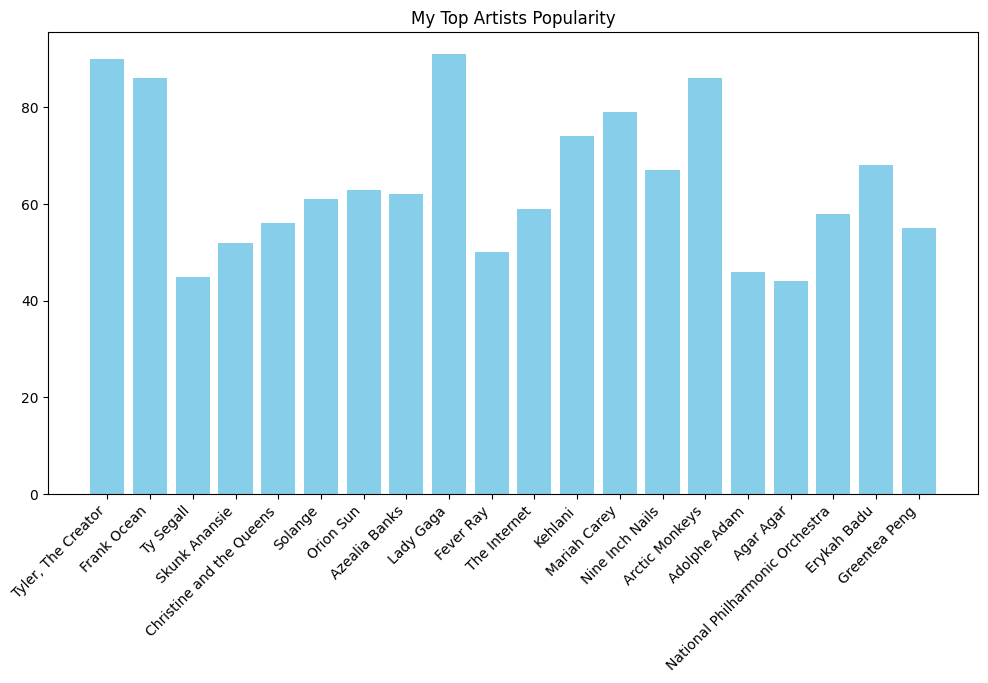

In [73]:
plt.figure(figsize=(12, 6))
plt.bar(my_artists_cleaned['name'], my_artists_cleaned['popularity'], color='skyblue')
plt.title('My Top Artists Popularity')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

## _my top genres in top artists_

In [74]:

my_genres = [genre for sublist in cleaned_df['Genres'].str.split(', ') for genre in sublist]
genre_count = Counter(my_genres)
labels, sizes = zip(*genre_count.most_common(10))


C:\Users\AARON\AppData\Local\Temp\ipykernel_7084\635442572.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette='colorblind')


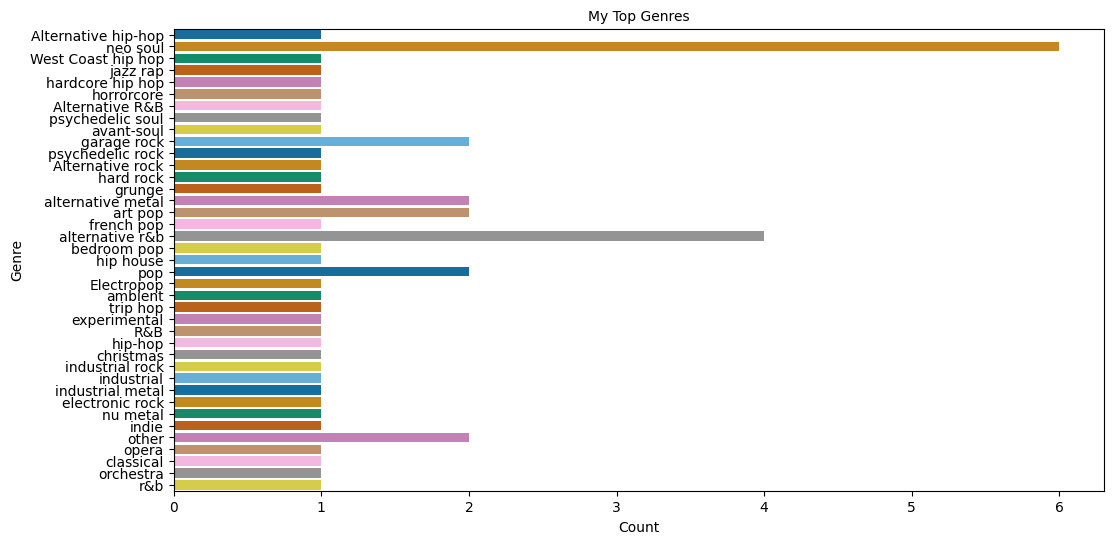

In [75]:

plt.figure(figsize=(12,6))
sns.barplot(x=list(genre_count.values()), y=list(genre_count.keys()), palette='colorblind')
plt.xlabel("Count")
plt.ylabel("Genre")
plt.title('My Top Genres', fontsize=10)
plt.show()


## top tracks from top artists

In [76]:
#my_artists_df['name']

In [77]:
def tracks_from_artists(my_artists_df, time_range='medium_term', limit=50):
    results = sp.current_user_top_tracks(time_range=time_range,  limit=limit)
    tracks = []
    
    # print raw
    
    #print("Raw top tracks fetched:")
    #for item in results['items']:
    #    print(item['name'], "by", [artist['name'] for artist in item['artists']])
    
    #grab top artist names
    top_artist_names = set(my_artists_df['name'])
    
    for item in results['items']:
        artist_per_track = [artist['name'] for artist in item['artists']]

        if any(artist in top_artist_names for artist in artist_per_track):
            tracks.append({
                'track name': item['name'],
                'artists': ', '.join(artist_per_track),
                'album': item['album']['name'],
                'release': item['album']['release_date'],
                'track id': item['id'],
                'popularity': item['popularity']
            })
            
    tracks_df = pd.DataFrame(tracks)
    return tracks_df

### Why use a set instead of a list? - refresher from chatgpt

* Faster lookups: Checking membership in a set (O(1) average time) is much faster than searching in a list(O(n)).
* Avoids duplicates: A set automatically removes duplicate artist names.
* Better performance: If you have 50 top tracks, each with multiple artists, checking each one against a list of 20 top artists would be O(50 × 20) = 1000 checks. With a set, it remains O(50).

🌟 TLDR:
Using set(df_artists['Name']) ensures faster filtering when checking if a track's artist is in your top artists. 🚀

In [78]:
my_top_tracks_from_top_artists_df = tracks_from_artists(my_artists_df)
my_top_tracks_from_top_artists_df['release'] =my_top_tracks_from_top_artists_df['release'].apply(date_clean)
my_top_tracks_from_top_artists_df.head()


,track name,artists,album,release,track id,popularity
0,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024,2plbrEY59IikOBgBGLjaoe,98
1,Brazen (Weep),Skunk Anansie,Stoosh,1996,1mSVdpc7uHEXYfKVtHd1su,40
2,Charlie Big Potato,Skunk Anansie,Post Orgasmic Chill,1999,7FY6MkxmeSt6WSeC0XnY5m,42
3,Pink + White,Frank Ocean,Blonde,2016,3xKsf9qdS1CyvXSMEid6g8,84
4,Big eye,Christine and the Queens,"PARANOÏA, ANGELS, TRUE LOVE",2023,0fGbCVPP41cReDwIAuOORJ,21


# top tracks

In [79]:
# get top tracks

def get_tracks(time_range='medium_term', limit=20):
    results = sp.current_user_top_tracks(time_range=time_range, limit=limit)
    t_tracks = []

    for item in results['items']:
        track_artists = [artist['name'] for artist in item['artists']]
        t_tracks.append({
            'track name': item['name'],
            'artists': ', '.join(track_artists),
            'album': item['album']['name'],
            'release': item['album']['release_date'],
            'track id': item['id'],
            'popularity': item['popularity']
        })
    top_tracks_df = pd.DataFrame(t_tracks)
    return top_tracks_df

In [80]:
my_tracks_df = get_tracks()
my_tracks_df['release'] = my_tracks_df['release'].apply(date_clean)
my_tracks_df.head()


,track name,artists,album,release,track id,popularity
0,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024,2plbrEY59IikOBgBGLjaoe,98
1,Silencer,Dub War,Wrong Side Of Beautiful,1996,1premcRnMNh9KvM7WWtgz5,13
2,Brazen (Weep),Skunk Anansie,Stoosh,1996,1mSVdpc7uHEXYfKVtHd1su,40
3,Charlie Big Potato,Skunk Anansie,Post Orgasmic Chill,1999,7FY6MkxmeSt6WSeC0XnY5m,42
4,Pink + White,Frank Ocean,Blonde,2016,3xKsf9qdS1CyvXSMEid6g8,84


### merge my_top_tracks and my_top_tracks_from_top_artists_df

In [81]:
all_top_tracks = pd.concat([my_tracks_df, my_top_tracks_from_top_artists_df]).reset_index(drop=True).drop_duplicates(subset=['track id'])

* want - to visualise the years my top tracks span or move through...
* need:
    * clean the release dates for yyyy
    * find the best choices to visualise 

In [82]:

all_top_tracks['release'] = all_top_tracks['release'].apply(date_clean)


In [83]:
all_top_tracks.head()

,track name,artists,album,release,track id,popularity
0,Die With A Smile,"Lady Gaga, Bruno Mars",Die With A Smile,2024,2plbrEY59IikOBgBGLjaoe,98
1,Silencer,Dub War,Wrong Side Of Beautiful,1996,1premcRnMNh9KvM7WWtgz5,13
2,Brazen (Weep),Skunk Anansie,Stoosh,1996,1mSVdpc7uHEXYfKVtHd1su,40
3,Charlie Big Potato,Skunk Anansie,Post Orgasmic Chill,1999,7FY6MkxmeSt6WSeC0XnY5m,42
4,Pink + White,Frank Ocean,Blonde,2016,3xKsf9qdS1CyvXSMEid6g8,84


# playlists

### get all

In [84]:
def get_playlists():
    results = sp.current_user_playlists()
    all_playlists = []

    while results:
        for playlist in results['items']:
            all_playlists.append({
                "playlist_name": playlist["name"],
                "total_tracks": playlist["tracks"]["total"],
                "playlist_id": playlist["id"]
            })
        # pagination
        if results["next"]:
            results = sp.next(results)
        else:
            break
    
    all_playlists = pd.DataFrame(all_playlists)
    return all_playlists


In [85]:
my_playlists = get_playlists()
my_playlists.head()

,playlist_name,total_tracks,playlist_id
0,Random Playlist from AHS,20,48bzRbnOaEXLs7onEuf888
1,My top tracks playlist,5,5tdLL7KmCjme8n59qBtycv
2,Gaga in order,25,1VK03kdKyRNc86QkdqFmj9
3,?,1,2Jla4LLDdGndqCKxP7ZeIo
4,mmmm,21,0a68WVAAQcjjlddZGijvOG


* loop through tracks
    * for id in myplaylists
    * sp.playlisttracks(id)


In [86]:
def get_playlist_tracks(my_playlists, limit=50):
    playlist_tracks = []

    for playlist_id in my_playlists['playlist_id']:
        results = sp.playlist_tracks(playlist_id, limit=limit)  # Get tracks from the playlist

        for item in results['items']:
            track = item.get('track')  # Ensure track data is extracted safely
            
            if track:  # Ensure track data exists
                playlist_tracks.append({
                    'track_name': track['name'],
                    'artists': ', '.join([artist['name'] for artist in track['artists']]),
                    'album': track['album']['name'],
                    'release_year': track['album']['release_date'],
                    'track_id': track['id'],
                    'popularity': track['popularity']
                })
    
    # Convert the list of tracks into a DataFrame
    tracks_df = pd.DataFrame(playlist_tracks)

    return tracks_df

In [87]:
# Call the function to test
my_tracks_from_playlists = get_playlist_tracks(my_playlists)

my_tracks_from_playlists.drop_duplicates(subset=['track_id'], keep='first', inplace=True)

my_tracks_from_playlists['release_year'] = my_tracks_from_playlists['release_year'].apply(date_clean)


In [88]:
my_tracks_from_playlists.rename(columns={'track_name': 'track name', 'release_year': 'release year', 'track_id': 'track id'}, inplace=True)

In [89]:
my_tracks_from_playlists.head()

,track name,artists,album,release year,track id,popularity
0,Marry The Night,Lady Gaga,Born This Way (International Special Edition V...,2011,02d1E4NRuh7OEQO4vCb9PD,60
1,10 or a 2-way,Korn,See You On the Other Side,2005,317voMksLU98NZn3wlFUsG,38
2,No One,Alicia Keys,As I Am (Expanded Edition),2007,6IwKcFdiRQZOWeYNhUiWIv,69
3,Maybe This Time,Liza Minnelli,Cabaret (Original Soundtrack Recording),1972,2Oam4p5G5GfyzLLBuMTJty,46
4,Coming Undone,Korn,See You On the Other Side,2005,3o7TMr6RmIusYH7Kkg7ujR,73


## convert to csv for creat_paylist script

In [90]:
my_tracks_from_playlists.to_csv('my_playlist_tracks.csv')

# albums [] - if album in all_top_tracks and album in my_tracks_from_playlists: albums.append(aalbum, artist) - print albums

* which albums occur across top tracks and playlists?

In [91]:
#iitterrows

# use set to remove duplicates - for now i only want to see a list - so, list(set(albums))????

In [92]:
albums = []

#loop through all tracks
for index1, row1 in all_top_tracks.iterrows():
    album1 = row1['album']
    artist1 = row1['artists']

    artist1 = artist1.split(',')[0] 
        
    if album1 in my_tracks_from_playlists['album'].values:
        albums.append((album1, artist1))

albums = list(set(albums))

pprint.pprint(albums)

[('channel ORANGE', 'Frank Ocean'),
 ('A Collection of Fleeting Moments and Daydreams', 'Orion Sun'),
 ('Goodbye Bread', 'Ty Segall'),
 ('Wrong Side Of Beautiful', 'Dub War'),
 ('Radical Romantics', 'Fever Ray'),
 ('Tchaikovsky: Swan Lake', 'Pyotr Ilyich Tchaikovsky'),
 ('La vita nuova', 'Christine and the Queens'),
 ('Plunge', 'Fever Ray'),
 ('Redcar les adorables étoiles (prologue)', 'Christine and the Queens'),
 ('In Rainbows', 'Radiohead'),
 ('A Seat at the Table', 'Solange'),
 ("I Ain't Movin'", "Des'ree"),
 ('Blonde', 'Frank Ocean'),
 ('PARANOÏA, ANGELS, TRUE LOVE', 'Christine and the Queens')]
